In [27]:
#kernel stuff
sig=0.5
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import sys
class extension_cluster_kernel:
    def __init__(self, data, type, parameters=None):
        self.dict = {}
        for i,d in enumerate(data):
            self.dict[d.tobytes()] = i
        sigma=sig
        gam = 1/(2*sigma**2)
        K = rbf_kernel(data,gamma = gam)
        D = np.zeros((K.shape[0],K.shape[1]))
        diagonalElements = np.sum(K,axis = 1)
        for i in range(D.shape[0]):
            D[i,i] = diagonalElements[i]**(-0.5)
        L = (D.dot(K)).dot(D)
        self.L = L
        self.eigvalues,self.eigvectors = np.linalg.eigh(L)
        if parameters:
            self.K = getattr(self, type)(parameters)
        else:
            self.K = getattr(self, type)()
    def compute_K(self,L):
        D_hat = np.diag((1./(np.diagonal(L) + sys.float_info.epsilon))**(0.5))
        K_hat = (D_hat.dot(L)).dot(D_hat)
        return K_hat
    def linear(self):
        return self.compute_K(self.L)
    def step(self,r):
        tmp_eig = np.zeros((len(self.eigvalues),len(self.eigvalues)))
        indeces = np.argsort(self.eigvalues)[::-1]
        best = indeces[:r]
        for i in range(self.eigvalues.shape[0]):
            if i in best:
                tmp_eig[i,i] = 1
            else:
                tmp_eig[i,i] = 0
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def linear_step(self,r):
        tmp_eig = np.diag(self.eigvalues)
        for i,e in enumerate(self.eigvalues):
            if e < r:
                tmp_eig[i,i] = 0
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def polynomial(self,t):
        tmp_eig = np.diag(np.power(self.eigvalues,t))
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def poly_step(self,parameter_list):
        r = parameter_list[0]
        p = parameter_list[1]
        q = parameter_list[2]
        
        tmp_eig = np.zeros((len(self.eigvalues),len(self.eigvalues)))
        
        indeces = np.argsort(self.eigvalues)[::-1]
        #print(self.eigvalues[indeces])
        best = indeces[:r]
        for i,e in enumerate(self.eigvalues):
            if i in best:
                tmp_eig[i,i] = np.power(e,p)
            else:
                tmp_eig[i,i] = np.power(e,q)
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    
    def distance(self,X1,X2):
            gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
            index2list = np.zeros((X2.shape[0]),dtype=int)
            for j, x2 in enumerate(X2):
                index2list[j] = self.dict[x2.tobytes()]
            for i, x1 in enumerate(X1):
                ind1 = self.dict[x1.tobytes()]
                #print('in sample:',i)
                #print(np.ndarray.tobytes())
                #print('in the kernel',ind1)
                gram_matrix[i, :] = self.K[ind1,index2list]
            #print(gram_matrix.shape)
            return gram_matrix

In [31]:
#USPS_results replication
from sklearn import svm
import numpy as np
from tsvm import TSVM
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def k_th_largest_eig(eig,k):
    arr = eig.copy()
    arr.sort() 
    return arr[-k]


with open ('20news_databases', 'rb') as fp:
    news_file = pickle.load(fp) 

labeled = news_file[0]
unlabeled = news_file[1]
df_test = news_file[2]

df_train = pd.concat((labeled,unlabeled))


def get_mean_and_std(method='svm'):
    sigma=sig
    #accuracy = np.zeros(50)
    gam = 1/(2*sigma**2)
    
    accuracy=np.zeros(100)
    for i in range(100):
        
        if(method=='cluster_kernel'): #cluster kernel
            trn = df_train.iloc[:,:-1].to_numpy()
            #print(trn)
            tes = df_test.iloc[:,:-1].to_numpy()
            data = np.concatenate((trn,tes),axis=0)
            #print('data dimensions', data.shape)
            lin_ker = extension_cluster_kernel(data,'linear')
            eig = lin_ker.eigvalues
            #print('eig:',eig)
            #print('eig length:',eig.shape)
            cut_off = k_th_largest_eig(eig,10)
            #print('cut_off:',cut_off)
            #lin_ker.poly_step([cut_off,1/2,2])
            #lin_ker.polynomial(5)
            lin_ker.poly_step([10,1/2,2])
            labeled_w = df_train.loc[df_train['Labels']==-1].sample(8,random_state=i)
            labeled_m = df_train.loc[df_train['Labels']==1].sample(8,random_state=i)
            labeled = pd.concat((labeled_w,labeled_m))
            unlabeled = df_train.drop(labeled.index)
            
            print('labeled size',labeled.loc[labeled['Labels']==1].shape)
            #print('unlabeled size',unlabeled.shape)
            
            targets = labeled.iloc[:,-1].to_numpy()
            inputs =  labeled.iloc[:,:-1].to_numpy()
            unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
            unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
            test_inputs = df_test.iloc[:,:-1].to_numpy()
            test_targets= df_test.iloc[:,-1].to_numpy()


            clf = svm.SVC(kernel=lin_ker.distance, C=100,class_weight='balanced')
            #print('number of +1:',targets[targets==1].shape)
            #print('number of -1:',targets[targets==-1].shape)
            #print('inputs size:',inputs.shape)
            clf.fit(inputs,targets)
            #print('test:',test_inputs.shape)
            accuracy[i] = clf.score(test_inputs,test_targets)
            print('accuracy at iteration:',accuracy[i]) 
        elif(method=='svm'): #svm
            
            
            labeled_w = df_train.loc[df_train['Labels']==-1].sample(8,random_state=i)
            labeled_m = df_train.loc[df_train['Labels']==1].sample(8,random_state=i)
            labeled = pd.concat((labeled_w,labeled_m))
            unlabeled = df_train.drop(labeled.index)
            
            
            targets = labeled.iloc[:,-1].to_numpy()
            inputs =  labeled.iloc[:,:-1].to_numpy()
            unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
            unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
            test_inputs = df_test.iloc[:,:-1].to_numpy()
            test_targets= df_test.iloc[:,-1].to_numpy()
            
            
            
            #print(inputs_scaled.std(axis=0))
            #pca = PCA(n_components = 0.95, svd_solver='full')
            #pca.fit(inputs)
            #transformed_inputs = pca.transform(inputs)
            #transformed_test_inputs = pca.transform(test_inputs)
            clf = svm.SVC(kernel='rbf', C=100,gamma=gam,class_weight='balanced')
            clf.fit(inputs, targets)
            accuracy[i] = clf.score(test_inputs,test_targets)
            print('accuracy at iteration:',accuracy[i])
            '''print('sigma:', sigma)
            print(accuracy)
            print('mean:', np.mean(accuracy))
            print('std:', np.std(accuracy))'''
        elif(method=='tsvm'):#tsvm

            #for each i, use partition[i] as train, and the rest as test
            
            labeled_w = df_train.loc[df_train['Labels']==-1].sample(8,random_state=i)
            labeled_m = df_train.loc[df_train['Labels']==1].sample(8,random_state=i)
            labeled = pd.concat((labeled_w,labeled_m))
            unlabeled = df_train.drop(labeled.index)
            
            
            targets = labeled.iloc[:,-1].to_numpy()
            inputs =  labeled.iloc[:,:-1].to_numpy()
            unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
            unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
            test_inputs = df_test.iloc[:,:-1].to_numpy()
            test_targets= df_test.iloc[:,-1].to_numpy()
            clf = TSVM()
            C = 100
            clf.initial('rbf',gam,C,1.5,8)
            clf.train(inputs,targets,unlabeled_inputs)
            test_predict = clf.predict(test_inputs)
            accuracy[i] = test_predict[test_predict==test_targets].size/test_predict.size
            print(accuracy[i])
            #clf = svm.SVC(kernel='rbf', C=10,gamma=gam,class_weight='balanced')
            #clf.fit(inputs, targets)
            #accuracy[i] = clf.score(test_inputs,test_targets)
            '''print(accuracy)
            print('mean:', np.mean(accuracy))
            print('std:', np.std(accuracy))'''
        else:#random walk
            print('random walk initiated')
            targets = labeled.iloc[:,-1].to_numpy()
            inputs =  labeled.iloc[:,:-1].to_numpy()
            unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
            unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
            test_inputs = df_test.iloc[:,:-1].to_numpy()
            test_targets= df_test.iloc[:,-1].to_numpy()
            unl_total = np.concatenate((unlabeled_inputs,test_inputs))

            rw = random_walk(inputs,targets,unl_total,gam,10,8)
            res = rw.results
            #print(res)
            print(res.shape)
            #test_predict = clf.predict(test_inputs)
            #accuracy[i] = 
            #print(accuracy[i])
            predicted_res = res[inputs.shape[0]+unlabeled_inputs.shape[0]:]
            #print(predicted_res.shape)
            targ = np.concatenate((unlabeled_targets,test_targets))
            #print(targ.shape)
            accuracy[i] = test_targets[test_targets==predicted_res].shape[0]/test_targets.shape[0]
            print(accuracy[i])
    print(accuracy)
    print('mean',accuracy.mean())
    print('std',accuracy.std())



In [32]:
class random_walk:
    def __init__(self,labeledData,labels,unlabeledData,gam=None,k=1,t=2):
        data = np.concatenate((labeledData,unlabeledData))
        L = labeledData.shape[0]
        N = data.shape[0]
        labels = (1==labels)*1
        self.W = rbf_kernel(data,gamma=gam)
        for i in range((self.W).shape[0]):
            sort = list(np.argsort(self.W[i]))
            sort.remove(i)
            for j in sort[k:]:
                self.W[i,j]=0
                
        self.W = np.maximum(self.W,(self.W).transpose())
        self.P=np.zeros(((self.W).shape))
        sumRowsW = np.sum(self.W,axis=1)
        for i in range((self.W).shape[0]):
            self.P[i]=self.W[i]/sumRowsW[i]
        
        self.PT = np.linalg.matrix_power(self.P,t)
        
        self.labelProbability = np.zeros((N,2))
        #Initializing random values
        for i in range(N):
            number = (0.5 - np.random.rand())*0.4
            self.labelProbability[i,0] = 0.5+number
            self.labelProbability[i,1]=1-self.labelProbability[i,0]
        
        self.probability = np.zeros((N,L))
        oldloglike = -np.inf
        self.loglike = np.zeros(100)
        for iter in range(100):
            #E Step
            for i in range(N):
                for j in range(L):
                    self.probability[i,j] = self.labelProbability[i,labels[j]]*self.PT[i,j]
                    
            #M Step
            for i in range(N):
                self.labelProbability[i,0] = (np.sum((labels==0)*self.probability[i]))/(np.sum(self.probability[i])+sys.float_info.epsilon)
                self.labelProbability[i,1] = (np.sum((labels==1)*self.probability[i]))/(np.sum(self.probability[i])+sys.float_info.epsilon)
            self.loglike[iter] = np.sum(np.log(np.sum(self.probability,axis=0)))
            if np.abs(self.loglike[iter] - oldloglike) < 10**(-4):
                break
            oldloglike = self.loglike[iter]
        
        self.posterior = np.matmul((self.labelProbability).transpose(),self.PT)
        self.results = ((np.argmax(self.posterior,axis = 0))*2)-1

In [33]:
get_mean_and_std(method='cluster_kernel')

labeled size (8, 7512)
accuracy at iteration: 0.8386666666666667
labeled size (8, 7512)
accuracy at iteration: 0.8053333333333333
labeled size (8, 7512)
accuracy at iteration: 0.7986666666666666
labeled size (8, 7512)
accuracy at iteration: 0.8186666666666667
labeled size (8, 7512)
accuracy at iteration: 0.7906666666666666
labeled size (8, 7512)
accuracy at iteration: 0.8253333333333334
labeled size (8, 7512)
accuracy at iteration: 0.8253333333333334
labeled size (8, 7512)
accuracy at iteration: 0.768
labeled size (8, 7512)
accuracy at iteration: 0.7986666666666666
labeled size (8, 7512)
accuracy at iteration: 0.8
labeled size (8, 7512)
accuracy at iteration: 0.824
labeled size (8, 7512)
accuracy at iteration: 0.8253333333333334
labeled size (8, 7512)
accuracy at iteration: 0.8
labeled size (8, 7512)
accuracy at iteration: 0.832
labeled size (8, 7512)
accuracy at iteration: 0.8266666666666667
labeled size (8, 7512)
accuracy at iteration: 0.8306666666666667
labeled size (8, 7512)
accura

In [25]:
get_mean_and_std(method='svm')

accuracy at iteration: 0.6666666666666666
accuracy at iteration: 0.7093333333333334
accuracy at iteration: 0.6533333333333333
accuracy at iteration: 0.656
accuracy at iteration: 0.6253333333333333
accuracy at iteration: 0.6613333333333333
accuracy at iteration: 0.656
accuracy at iteration: 0.64
accuracy at iteration: 0.6266666666666667
accuracy at iteration: 0.716
accuracy at iteration: 0.6986666666666667


KeyboardInterrupt: 

In [223]:
def JH_bound(dataTrain,targets,dataTest):
    data = np.concatenate((dataTrain,dataTest))
    kern = extension_cluster_kernel(data,'linear')
    linearEigval = -np.sort(-kern.eigvalues)[:(dataTrain.shape[0])+16]
    print(linearEigval)
    T = np.zeros((len(linearEigval)))
    for i,lamda_cut in enumerate(linearEigval):
        kern.poly_step([lamda_cut,1/2,2])
        clf = svm.SVC(C=100,kernel=kern.distance)
        clf.fit(dataTrain,targets)
        #print(clf.dual_coef_)
        alphas = np.abs(clf.dual_coef_).reshape(-1)
        #alphas = clf.dual_coef_.reshape(-1)
        supportV = clf.support_
        for j in range(len(alphas)):
            T[i] += ((alphas[j]*kern.K[supportV[j],supportV[j]]-1)>0)*1
            print(T[i])
        T[i] = T[i]/dataTrain.shape[0]
    return T

In [224]:
targets = labeled.iloc[:,-1].to_numpy()
inputs =  labeled.iloc[:,:-1].to_numpy()
unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
test_inputs = df_test.iloc[:,:-1].to_numpy()
test_targets= df_test.iloc[:,-1].to_numpy()

tst = np.concatenate((unlabeled_inputs,test_inputs))
s = JH_bound(inputs,targets,tst)

print(s)

[1.         0.08703921 0.08471001 0.07666531 0.06992561 0.06540756
 0.06445777 0.06258194 0.0622008  0.06159176 0.06057623 0.05922764
 0.05895399 0.05847621 0.05838347 0.05786304 0.05735867 0.05712649
 0.05667154 0.05583205 0.05505665 0.05417577 0.05362878 0.05338223
 0.05314504 0.05307149 0.05295133 0.05235458 0.05219406 0.05189907
 0.05166393 0.05136487]
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
13.0
14.0
15.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
13.0
14.0
15.0
1.0
2.0
3.0
4.0
4.0
5.0
5.0
6.0
7.0
7.0
7.0
8.0
8.0
9.0
10.0
1.0
2.0
2.0
3.0
3.0
4.0
5.0
5.0
6.0
7.0
7.0
7.0
8.0
9.0
10.0
11.0
1.0
2.0
2.0
3.0
3.0
4.0
5.0
5.0
6.0
7.0
7.0
7.0
8.0
9.0
10.0
11.0
1.0
2.0
2.0
3.0
3.0
4.0
5.0
5.0
6.0
7.0
8.0
8.0
9.0
9.0
10.0
11.0
1.0
2.0
2.0
3.0
4.0
5.0
5.0
6.0
7.0
7.0
7.0
8.0
8.0
9.0
10.0
1.0
2.0
2.0
3.0
4.0
5.0
5.0
6.0
7.0
7

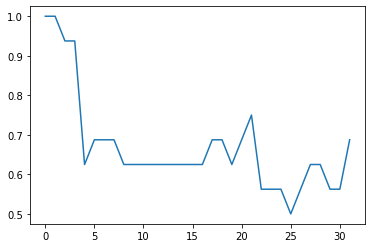

In [225]:
import matplotlib.pyplot as plt

plt.plot(s)

In [48]:
#time to generate figure_2

sizes = [2,4,8,16,32,64,128]

accuracy=np.zeros((4,len(sizes)))
it=0
for s in sizes:

    accuracy1=np.zeros(2)
    accuracy2=np.zeros(2)
    accuracy3=np.zeros(2)
    accuracy4=np.zeros(2)
    for i in range(2):

        trn = df_train.iloc[:,:-1].to_numpy()
        tes = df_test.iloc[:,:-1].to_numpy()
        data = np.concatenate((trn,tes),axis=0)

        lin_ker = extension_cluster_kernel(data,'linear')
        eig = lin_ker.eigvalues


        labeled_w = df_train.loc[df_train['Labels']==-1].sample(int(s/2),random_state=i)
        labeled_m = df_train.loc[df_train['Labels']==1].sample(int(s/2),random_state=i)
        labeled = pd.concat((labeled_w,labeled_m))
        unlabeled = df_train.drop(labeled.index)


        targets = labeled.iloc[:,-1].to_numpy()
        inputs =  labeled.iloc[:,:-1].to_numpy()
        unlabeled_targets=unlabeled.iloc[:,-1].to_numpy()
        unlabeled_inputs =unlabeled.iloc[:,:-1].to_numpy()
        test_inputs = df_test.iloc[:,:-1].to_numpy()
        test_targets= df_test.iloc[:,-1].to_numpy()


        clf = svm.SVC(kernel=lin_ker.distance, C=100,class_weight='balanced')
        clf.fit(inputs,targets)
        accuracy1[i] = clf.score(test_inputs,test_targets)


        #poly 

        lin_ker = extension_cluster_kernel(data,'polynomial',5)

        clf = svm.SVC(kernel=lin_ker.distance, C=100,class_weight='balanced')
        clf.fit(inputs,targets)
        accuracy2[i] = clf.score(test_inputs,test_targets)


        #step 
        
        lin_ker = extension_cluster_kernel(data,'linear')
        eig = lin_ker.eigvalues
        #cut_off = k_th_largest_eig(eig,s+10)
        lin_ker.step(s+10)
        #lin_ker.poly_step([cut_off,1/2,2])
        
        k1 = lin_ker.K
        
        clf = svm.SVC(kernel=lin_ker.distance, C=100,class_weight='balanced')
        clf.fit(inputs,targets)
        accuracy3[i] = clf.score(test_inputs,test_targets)
        print('step:',accuracy3)
        lin_ker = extension_cluster_kernel(data,'linear')
        eig = lin_ker.eigvalues
        #cut_off = k_th_largest_eig(eig,s+10)
        lin_ker.poly_step([s+10,1/2,2])
        
        k2 = lin_ker.K
        
        #print('the same?', k1==k2)
        
        accuracy4[i] = clf.score(test_inputs,test_targets)
        print('poly_step:',accuracy4)
    
    accuracy[0][it] = accuracy1.mean()
    accuracy[1][it] = accuracy2.mean()
    accuracy[2][it] = accuracy3.mean()
    accuracy[3][it] = accuracy4.mean()
    it=it+1
    print(it)
print(accuracy)

step: [0.636 0.   ]
poly_step: [0.636 0.   ]
step: [0.636 0.32 ]
poly_step: [0.636 0.32 ]
1
step: [0.73333333 0.        ]
poly_step: [0.73333333 0.        ]
step: [0.73333333 0.59733333]
poly_step: [0.73333333 0.59733333]
2
step: [0.79466667 0.        ]
poly_step: [0.79466667 0.        ]
step: [0.79466667 0.672     ]
poly_step: [0.79466667 0.672     ]
3
step: [0.736 0.   ]
poly_step: [0.736 0.   ]
step: [0.736      0.68933333]
poly_step: [0.736      0.68933333]
4
step: [0.73733333 0.        ]
poly_step: [0.73733333 0.        ]
step: [0.73733333 0.688     ]
poly_step: [0.73733333 0.688     ]
5
step: [0.73066667 0.        ]
poly_step: [0.73066667 0.        ]
step: [0.73066667 0.708     ]
poly_step: [0.73066667 0.708     ]
6
step: [0.672 0.   ]
poly_step: [0.672 0.   ]
step: [0.672 0.672]
poly_step: [0.672 0.672]
7
[[0.52666667 0.552      0.62866667 0.68933333 0.75133333 0.79333333
  0.83333333]
 [0.49266667 0.50533333 0.57733333 0.53466667 0.722      0.69133333
  0.864     ]
 [0.478     

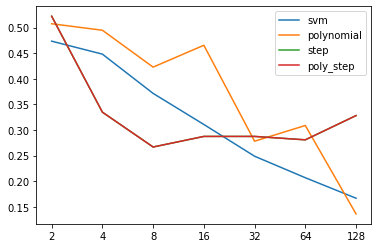

In [49]:
import matplotlib.pyplot as plt

plt.plot(1-accuracy[0],label='svm')
plt.plot(1-accuracy[1],label='polynomial')
plt.plot(1-accuracy[2],label='step')
plt.plot(1-accuracy[3],label='poly_step')
plt.xticks(np.arange(len(sizes)),sizes)
plt.legend()

In [39]:
trn = df_train.iloc[:,:-1].to_numpy()
tes = df_test.iloc[:,:-1].to_numpy()
data = np.concatenate((trn,tes),axis=0)

lin_ker = extension_cluster_kernel(data,'linear')
eig = lin_ker.eigvalues
print(eig)

[1.29003517e-18 1.14317231e-03 1.17630483e-03 1.58292109e-03
 3.38321045e-03 6.43343233e-03 6.87460402e-03 8.75143290e-03
 1.01881947e-02 1.05930844e-02 1.07378471e-02 1.12457728e-02
 1.31371957e-02 1.31931624e-02 1.41345781e-02 1.57030534e-02
 1.58372785e-02 1.66091261e-02 1.69747807e-02 1.77596785e-02
 1.96941503e-02 2.01342689e-02 2.09871682e-02 2.12808983e-02
 2.17158877e-02 2.25559740e-02 2.28265032e-02 2.34286178e-02
 2.38537922e-02 2.40610042e-02 2.42372399e-02 2.44154763e-02
 2.44723848e-02 2.47219828e-02 2.50680048e-02 2.50720803e-02
 2.51413074e-02 2.53671283e-02 2.55076233e-02 2.55710051e-02
 2.57196548e-02 2.57931552e-02 2.59139461e-02 2.64497662e-02
 2.65015323e-02 2.66305585e-02 2.66608022e-02 2.66634241e-02
 2.67121306e-02 2.67601750e-02 2.68688270e-02 2.69283441e-02
 2.70093487e-02 2.70271645e-02 2.71166399e-02 2.71478670e-02
 2.71912024e-02 2.72368810e-02 2.72943066e-02 2.73421561e-02
 2.73854137e-02 2.74946733e-02 2.75416366e-02 2.76311081e-02
 2.76865885e-02 2.776462